In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision as tv
import art
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_threads = os.cpu_count()
print('CPU threads = {}'.format(num_threads))

cuda:0
CPU threads = 6


In [3]:
epochs = 30
batch_size = 128

In [4]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [5]:
permutation = np.random.permutation(X.shape[0])
X = X[permutation].astype(np.float32) / 255.0
X = X.reshape((X.shape[0], 1, 28, 28))
y = y[permutation].astype(np.long)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8)
print(X.shape)

(70000, 1, 28, 28)


In [6]:
X_max = X_train.max()
X_min = X_train.min()
print(X_min, X_max)

0.0 1.0


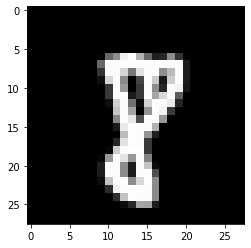

In [7]:
plt.figure()
plt.imshow(X[0, 0], cmap='gray')
plt.show()

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data)
        self.labels = torch.from_numpy(labels)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return len(self.data)

In [9]:
batch_size = 128

train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(
    train_dataset,
    batch_size,
    shuffle=True,
    num_workers=num_threads
)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(
    train_dataset,
    batch_size,
    shuffle=True,
    num_workers=num_threads
)

In [10]:
# Using built-in PyTorch DataLoader

# root = os.path.join('.', 'data')
# mean, std = [0.13066046], [0.30150425]

# transform = tv.transforms.Compose([
#         tv.transforms.ToTensor(),
#         tv.transforms.Normalize(mean, std)])
# train_dataset = tv.datasets.MNIST(
#     root,
#     train=True, 
#     download=True,
#     transform=transform)
# test_dataset = tv.datasets.MNIST(
#     root,
#     train=False, 
#     download=True,
#     transform=transform)

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=num_threads
# )
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=num_threads
# )

# X_max = 1.0
# X_min = 0.0

# it = iter(train_loader)
# x, _ = next(it)
# print(x.size())
# x = x.to(device)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 200)
        self.fc2 = nn.Linear(200, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        output = model(x)
        l = loss(output, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = output.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(train_loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [13]:
def validate(model, loader, loss):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            l = loss(output, y)
            total_loss += l.item() * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(test_loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [14]:
model = Net()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.NLLLoss()

In [15]:
# it = iter(train_loader)
# x, _ = next(it)
# print(x.size())
# x = x.to(device)
# model(x)

In [16]:
since = time.time()
for epoch in range(epochs):
    start = time.time()
    tr_loss, tr_acc = train(model, train_loader, loss, optimizer)
    va_loss, va_acc = validate(model, test_loader, loss)
    
    time_elapsed = time.time() - start
    print(('[{:2d}] {:.0f}m {:.1f}s Train Loss: {:.4f} Accuracy: {:.4f}%, ' +
        'Test Loss: {:.4f} Accuracy: {:.4f}%').format(
            epoch+1, time_elapsed // 60, time_elapsed % 60,
            tr_loss, tr_acc*100.,
            va_loss, va_acc*100.))
    
time_elapsed = time.time() - since
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

[ 1] 0m 3.3s Train Loss: 0.4306 Accuracy: 87.9839%, Test Loss: 0.1613 Accuracy: 95.0250%
[ 2] 0m 3.3s Train Loss: 0.1297 Accuracy: 95.9679%, Test Loss: 0.0971 Accuracy: 97.0393%
[ 3] 0m 3.3s Train Loss: 0.0844 Accuracy: 97.3875%, Test Loss: 0.0605 Accuracy: 98.0625%
[ 4] 0m 3.5s Train Loss: 0.0620 Accuracy: 98.0179%, Test Loss: 0.0464 Accuracy: 98.6089%
[ 5] 0m 3.3s Train Loss: 0.0468 Accuracy: 98.5268%, Test Loss: 0.0363 Accuracy: 98.8946%
[ 6] 0m 3.3s Train Loss: 0.0371 Accuracy: 98.8464%, Test Loss: 0.0286 Accuracy: 99.1464%
[ 7] 0m 3.3s Train Loss: 0.0286 Accuracy: 99.0893%, Test Loss: 0.0196 Accuracy: 99.3893%
[ 8] 0m 3.3s Train Loss: 0.0234 Accuracy: 99.2625%, Test Loss: 0.0151 Accuracy: 99.5821%
[ 9] 0m 3.3s Train Loss: 0.0184 Accuracy: 99.4107%, Test Loss: 0.0159 Accuracy: 99.5071%
[10] 0m 3.3s Train Loss: 0.0151 Accuracy: 99.5589%, Test Loss: 0.0125 Accuracy: 99.6339%
[11] 0m 3.3s Train Loss: 0.0127 Accuracy: 99.5929%, Test Loss: 0.0084 Accuracy: 99.8036%
[12] 0m 3.3s Train Lo

In [17]:
PyTorchClassifier = art.estimators.classification.PyTorchClassifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(X_min, X_max),
    loss=loss,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
    device_type=device
)

In [18]:
predictions = classifier.predict(X_test)
predictions = np.argmax(predictions, axis=1)
accuracy = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on test set: {}%".format(accuracy * 100))

Accuracy on test set: 98.82857142857144%


In [19]:
data_point = np.expand_dims(X_test[0], axis=0)

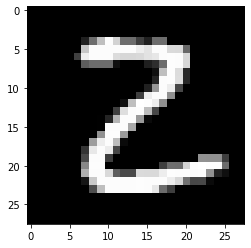

In [20]:
plt.figure()
plt.imshow(data_point[0, 0], cmap='gray')
plt.show()

[2] [3]


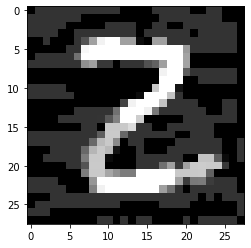

In [21]:
FastGradientMethod = art.attacks.evasion.FastGradientMethod
attack = FastGradientMethod(estimator=classifier, eps=0.2)
adv_test = attack.generate(x=data_point)
pred = classifier.predict(data_point)
pred = np.argmax(pred, axis=1)
adv_pred = classifier.predict(adv_test)
adv_pred = np.argmax(adv_pred, axis=1)
print(pred, adv_pred)

plt.figure()
plt.imshow(adv_test[0, 0], cmap='gray')
plt.show()

[2] [3]


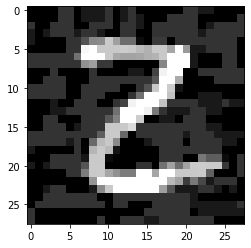

In [22]:
BIM = art.attacks.evasion.BasicIterativeMethod
attack = BIM(estimator=classifier, eps=0.2)
adv_test = attack.generate(x=data_point)
pred = classifier.predict(data_point)
pred = np.argmax(pred, axis=1)
adv_pred = classifier.predict(adv_test)
adv_pred = np.argmax(adv_pred, axis=1)
print(pred, adv_pred)

plt.figure()
plt.imshow(adv_test[0, 0], cmap='gray')
plt.show()

C&W L_2: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

[2] [3]


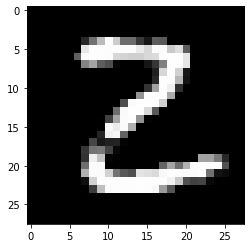

In [23]:
CW = art.attacks.evasion.CarliniL2Method
attack = CW(classifier)
adv_test = attack.generate(x=data_point)
pred = classifier.predict(data_point)
pred = np.argmax(pred, axis=1)
adv_pred = classifier.predict(adv_test)
adv_pred = np.argmax(adv_pred, axis=1)
print(pred, adv_pred)

plt.figure()
plt.imshow(adv_test[0, 0], cmap='gray')
plt.show()

DeepFool: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


[2] [3]


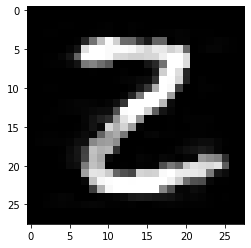

In [24]:
DeepFool = art.attacks.evasion.DeepFool
attack = DeepFool(classifier)
adv_test = attack.generate(x=data_point)
pred = classifier.predict(data_point)
pred = np.argmax(pred, axis=1)
adv_pred = classifier.predict(adv_test)
adv_pred = np.argmax(adv_pred, axis=1)
print(pred, adv_pred)

plt.figure()
plt.imshow(adv_test[0, 0], cmap='gray')
plt.show()

Pixel threshold: 1it [00:00,  4.55it/s]

[2] [2]


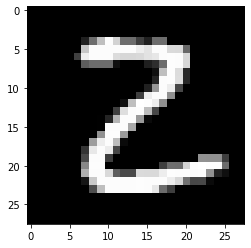

In [30]:
PixelAttack = art.attacks.evasion.PixelAttack
attack = PixelAttack(classifier)
adv_test = attack.generate(x=data_point)
pred = classifier.predict(data_point)
pred = np.argmax(pred, axis=1)
adv_pred = classifier.predict(adv_test)
adv_pred = np.argmax(adv_pred, axis=1)
print(pred, adv_pred)

plt.figure()
plt.imshow(adv_test[0, 0], cmap='gray')
plt.show()

Boundary attack: 100%|██████████| 1/1 [00:50<00:00, 50.31s/it]

[2] [8]


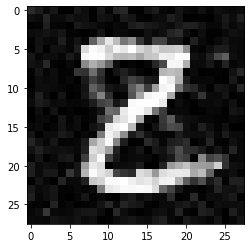

In [31]:
BoundaryAttack = art.attacks.evasion.BoundaryAttack
attack = BoundaryAttack(classifier, targeted=False)
adv_test = attack.generate(x=data_point)
pred = classifier.predict(data_point)
pred = np.argmax(pred, axis=1)
adv_pred = classifier.predict(adv_test)
adv_pred = np.argmax(adv_pred, axis=1)
print(pred, adv_pred)

plt.figure()
plt.imshow(adv_test[0, 0], cmap='gray')
plt.show()

ZOO: 100%|██████████| 1/1 [00:04<00:00,  4.58s/it]

[2] [2]
Attack failed!


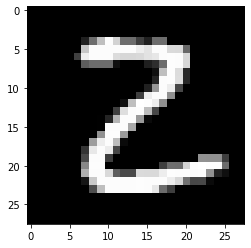

In [32]:
Zoo = art.attacks.evasion.ZooAttack
attack = Zoo(classifier, targeted=False, learning_rate=0.01, max_iter=100)
adv_test = attack.generate(x=data_point)
pred = classifier.predict(data_point)
pred = np.argmax(pred, axis=1)
adv_pred = classifier.predict(adv_test)
adv_pred = np.argmax(adv_pred, axis=1)
print(pred, adv_pred)
if pred == adv_pred:
    print('Attack failed!')


plt.figure()
plt.imshow(adv_test[0, 0], cmap='gray')
plt.show()

Pixel threshold: 0it [00:00, ?it/s]/home/lukec/venv/lib/python3.6/site-packages/art/attacks/evasion/pixel_threshold.py:1147: RuntimeWarning: divide by zero encountered in double_scalars
  and self.callback(self._scale_parameters(self.population[0]), convergence=self.tol / convergence,)
Pixel threshold: 1it [00:07,  7.59s/it]

[2] [2]


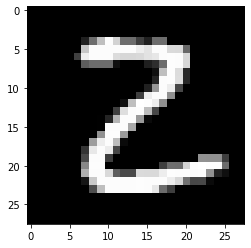

In [33]:
PixelAttack = art.attacks.evasion.PixelAttack
attack = PixelAttack(classifier, th=80, es=1, targeted=False)
adv_test = attack.generate(x=data_point)
pred = classifier.predict(data_point)
pred = np.argmax(pred, axis=1)
adv_pred = classifier.predict(adv_test)
adv_pred = np.argmax(adv_pred, axis=1)
print(pred, adv_pred)

plt.figure()
plt.imshow(adv_test[0, 0], cmap='gray')
plt.show()